## Aumento da Performance de Marketing

O Ifood é uma empresa de bem estabelecida do setor de varejo de alimentos no mercado brasileiro. Com milhares de clientes registrados e quase 1 milhão de consumidores por ano, eles vendem produtos divididos em 5 principais categorias: vinho, carnes, frutas, peixes e doces. 

Os clientes podem adquirir os produtos através de 3 canais de vendas: loja física, catálogos e site da empresa. O Ifood teve receitas sólidas nos últimos 3 anos, mas as perspectivas de crescimento dos lucros para os próximos 3 anos não são promissoras.

Pensando nisso, várias iniciativas estratégicas estão sendo consideradas para inverter essa situação. Uma delas é melhorar o desempenho de marketing, com foco especial em campanhas de marketing.


<center>
<img src = "https://github.com/guilhermediasmartins2/CaseIfood/blob/master/reports/figures/Online_Shoping_29.jpg" width = "60%">
<a href="https://br.freepik.com/vetores-gratis/equipe-de-entrega-andar-de-motocicletas-conceito-de-compras_11878958.htm#fromView=search&page=1&position=5&uuid=03df029c-f508-431f-a799-522debaad239">Image by studiogstock</a> on Freepik
</center>

Este projeto tem como objetivo realizar uma análise exploratória em uma base de dados que contém 2.240 clientes que foram contactados e mapeados nos meses seguintes durante a implantação de 5 campanhas. Assim, utilizarei a análise para entender o perfil dos clientes adeptos a elas, a fim de imaginar uma possível sexta campanha. Isso permitirá que a empresa escolha os clientes que são mais propensos a comprar a oferta e maximizar o lucro.

**Principais Indicadores Chave de Desempenho:**
- Taxa de Conversão para cada camanpanha já realizada;
- Taxa de Retenção de clientes entre campanhas.

### Importando os pacotes necessários

In [101]:
# Bibliotecas padrão
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scorecardpy as sc
import locale
import warnings


In [102]:
df = pd.read_csv(r'caminho')

# Funções Auxiliares

Foram criadas as seguintes funções para auxiliar na análise dos dados:

- "criar_coluna_binaria", onde recebe o dataframe e cria uma coluna de total de campanhas participadas por cada cliente e outra binária, indicando se o cliente participou ou não de alguma campanha;

- "identificar_tipo_variavel", onde recebe o dataframe, percorre todas as colunas e identifica o tipo de variável: Quantitativa Discreta, Quantitativa Contínua, Qualitativa Nominal ou Qualitativa Ordinária;

- "tabela_de_frequência", onde recebe o dataframe e a coluna, como resultado cria uma tabela de frequência para cada variável;

- "iv_woe", onde recebe o dataframe, a coluna binária e as colunas e como resultado apresenta uma tabela de cálculo do IV para cada variável;

- "classificar_e_destacar_iv", onde classifica cada variável de acordo com o IV;

- "classificar_variaveis_por_iv", onde cria um dataframe classificando as variáveis de acordo com o IV em ordem decrescente.

In [104]:
def criar_coluna_binaria(df):
    # Somando as colunas relevantes para criar a coluna binária
    df["AcceptedCmpTotal"] = df["AcceptedCmp1"] + df["AcceptedCmp2"] + df["AcceptedCmp3"] + df["AcceptedCmp4"] + df["AcceptedCmp5"]
    
    # Criando a coluna binária com base na soma
    df['HasAcceptedCmp'] = df["AcceptedCmpTotal"].apply(lambda x: 1 if x > 0 else 0)

    # Mantendo um registro das colunas envolvidas na criação da coluna binária
    colunas_utilizadas = ["AcceptedCmp1", "AcceptedCmp2", "AcceptedCmp3", "AcceptedCmp4", "AcceptedCmp5"]

    # Criando uma variável com as colunas utilizadas
    df_colunas_utilizadas = df[colunas_utilizadas].copy()

    return df, df_colunas_utilizadas, colunas_utilizadas

def identificar_tipo_variavel(df):
    tipos_variaveis = {}

    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            if np.issubdtype(df[col], np.float64) or np.issubdtype(df[col], np.int64):
                if len(df[col].unique()) < len(df) / 25:
                    tipos_variaveis[col] = "Quantitativa Discreta"
                else:
                    tipos_variaveis[col] = "Quantitativa Contínua"
        elif pd.api.types.is_string_dtype(df[col]) or pd.api.types.is_categorical_dtype(df[col]):
            tipos_variaveis[col] = "Qualitativa Nominal" 
            
            if hasattr(df[col].dtype, 'ordered') and df[col].dtype.ordered:
                tipos_variaveis[col] = "Qualitativa Ordinal"
    
    return tipos_variaveis

def tabela_de_frequencia(df, coluna):
    tipo_variavel = identificar_tipo_variavel(df)[coluna]

    if "Quantitativa" in tipo_variavel:
        dados = df[coluna]
        total = len(dados)

        # Definindo o número de faixas
        if len(dados.unique()) < 6 and "Discreta" in tipo_variavel:
            tabela = pd.DataFrame(dados.value_counts()).sort_index()
        else:
            # Dividir em faixas
            num_faixas = min(int(np.sqrt(len(dados.unique()))), 10)  # Limitando a 10 faixas no máximo
            faixas = pd.cut(dados, bins=num_faixas, precision=2, include_lowest=True, right=False)
            tabela = pd.DataFrame(faixas.value_counts()).sort_index()
            tabela.index = [f'{intervalo.left:.0f} - {intervalo.right:.0f}' for intervalo in tabela.index]

    elif "Qualitativa" in tipo_variavel:
        dados = df[coluna]
        tabela = pd.DataFrame(dados.value_counts()).sort_index()

    else:
        return "Tipo de variável não reconhecido."
        
    # Calcular a Frequência Absoluta para esse tipo de variável
    tabela.columns = ['Frequência Absoluta']  
    total_absoluto = tabela['Frequência Absoluta'].sum()
    tabela['Frequência Relativa'] = round((tabela['Frequência Absoluta'] / total_absoluto) * 100, 2)
    tabela['Frequência Acumulada'] = tabela['Frequência Relativa'].cumsum()
    
    # Verificando se alguma faixa possui frequência absoluta menor que 10
    i = 0
    while i < len(tabela):
        if tabela.iloc[i]['Frequência Absoluta'] < 10 and i < len(tabela) - 1:
            tabela.iloc[i+1]['Frequência Absoluta'] += tabela.iloc[i]['Frequência Absoluta']
            tabela.iloc[i+1]['Frequência Relativa'] += tabela.iloc[i]['Frequência Relativa']
            tabela.iloc[i+1]['Frequência Acumulada'] += tabela.iloc[i]['Frequência Acumulada']
            tabela.drop(tabela.index[i], inplace=True)
        else:
            i += 1
        
    # Incluindo linha 'Total'
    total_relativo = round(tabela['Frequência Relativa'].sum(),0)
    total_acumulado = round(tabela['Frequência Acumulada'].iloc[-1],0)
    tabela.loc['Total'] = [total_absoluto, total_relativo, total_acumulado]
    
    tabela.index.name = coluna
    tabela['Frequência Absoluta'] = tabela['Frequência Absoluta'].apply(round)
    tabela = tabela.reset_index(drop=False)
    
    return tabela

def iv_woe(df, target, colunas, bins=10, show_woe=False):
    
    # DataFrame para armazenar os resultados
    resultados = {}
    
    # Itera sobre as colunas
    for variavel in colunas:
        if variavel == target:
            continue  # Ignora a variável alvo e outras variáveis utilizadas na criação da coluna binária
            
        # Verifica o tipo de variável e, se for numérica com mais de 10 valores únicos, cria intervalos (bins)
        if (df[variavel].dtype.kind in 'bifc') and (len(np.unique(df[variavel])) > 10):
            binned_x = pd.qcut(df[variavel], bins, duplicates='drop')
            # Adiciona uma coluna com os intervalos
            d0 = pd.DataFrame({'Variavel': binned_x, 'Primeiro Valor': binned_x.apply(lambda interval: interval.left), 'y': df[target]})
                                
        else:
            d0 = pd.DataFrame({'Variavel': df[variavel], 'Primeiro Valor': df[variavel], 'y': df[target]})
            
        d0 = d0.astype({"Primeiro Valor": str})  # Convertendo a coluna 'Primeiro Valor' para string para evitar problemas de tipo
        d = d0.groupby("Variavel", as_index=False, dropna=False).agg({"y": ["count", "sum"]})
        d.columns = ['Variavel', 'Total Linha', 'Eventos']
        d['% de Eventos'] = round(np.maximum(d['Eventos'], 0.5) / d['Eventos'].sum()*100, 2)
        d['Não Eventos'] = d['Total Linha'] - d['Eventos']
        d['% de Não Eventos'] = round(np.maximum(d['Não Eventos'], 0.5) / d['Não Eventos'].sum()*100, 2)
        d['Taxa de Aceitação'] = round(d['Eventos'] / d['Total Linha']*100, 2)
        d['WOE'] = round(np.log(d['% de Eventos'] / d['% de Não Eventos']), 2)
        d['IV'] = d['WOE'] * (d['% de Eventos'] - d['% de Não Eventos'])/100
        
        # Adiciona uma linha "Total Geral"
        total_geral = round(d.sum(numeric_only=True), 0)
        total_geral['Variavel'] = 'Total Geral'
        total_geral['Primeiro Valor'] = 'Total Geral'
        total_geral['IV'] = d['IV'].sum()
        total_geral['WOE'] = round(np.log(total_geral['% de Eventos'] / total_geral['% de Não Eventos']), 2)
        total_geral['Taxa de Aceitação'] = round(total_geral['Eventos'] / total_geral['Total Linha'] * 100, 2)
        d = d.append(total_geral, ignore_index=True)
        d = d.drop(columns='Primeiro Valor')
        
        # Armazena os resultados da variável atual
        resultados[variavel] = d     
           
    return resultados

def exibir_resultados(resultados):
    for coluna, tabela in resultados.items():
        print(f"Resultados para a variável '{coluna}':")
        display(tabela)
        
def classificar_e_destacar_iv(valor):
    if valor < 0.02:
        return "Muito Fraco"
    elif 0.02 <= valor < 0.1:
        return "Fraco"
    elif 0.1 <= valor < 0.3:
        return "Médio"
    elif 0.3 <= valor < 0.5:
        return "Forte"
    else:
        return "Muito Forte"
    
def classificar_variaveis_por_iv(iv_resultados):
    iv_dict = {}
    for coluna, tabela in iv_resultados.items():
        iv = tabela.loc[tabela['Variavel'] == 'Total Geral', 'IV'].values[0]
        iv_dict[coluna] = iv

    iv_sorted = sorted(iv_dict.items(), key=lambda x: x[1], reverse=True)
    return iv_sorted

## **Análise dos Dados**

Esta seção fornece uma visão detalhada da estrutura e do significado dos dados que estão sendo analisados.

### **Dicionário de Variáveis**

- **`ID`**: é o número de idetnificação de cada cliente.

- **`Year_Birth`**: ano de nascimento do cliente.

- **`Education`**: grau de escolaridade do cliente.

- **`Marital_Status`**: o estado civil do cliente.

- **`Income`**: renda anual do cliente.

- **`Kidhome`**: número de crianças na casa do cliente.

- **`Teenhome`**: número de adolescentes na casa do cliente.

- **`Dt_Customer`**: data de inscrição do cliente na comapanhia.

- **`Recency`**: número de dias desde a última compra do cliente.

- **`MntWines`**: valor gasto em vinhos nos últimos 2 anos.

- **`MntFruits`**: valor gasto em frutas nos últimos 2 anos.

- **`MntMeatProducts`**: valor gasto em produtos de carne nos últimos 2 anos.

- **`MntFishPorducts`**: valor gasto em peixe nos últimos 2 anos.

- **`MntSweetProducts`**: valor gasto em doces no últimos 2 anos.

- **`MntGolProducts`**: valor gasto em produtos 'gold' nos últimos 2 anos.

- **`NumDealsPurchases`**: número de compras feitas com desconto.

- **`NumWebPurchases`**: número de compras feitas através do site da empresa.

- **`NumCatalogPurchases`**: número de compras feitas usando o catálogo.

- **`NumStorePurchases`**: número de compras feitas nas lojas.

- **`NumWebVisitsMonth`**: número de visitas no site da empresa no último mês.

- **`AcceptedCmp1`**: 1 se o cliente aceitou a oferta na 1a campanha, e 0 caso contrário.

- **`AcceptedCmp2`**: 1 se o cliente aceitou a oferta na 2a campanha, e 0 caso contrário.

- **`AcceptedCmp3`**: 1 se o cliente aceitou a oferta na 3a campanha, e 0 caso contrário.

- **`AcceptedCmp4`**: 1 se o cliente aceitou a oferta na 4a campanha, e 0 caso contrário.

- **`AcceptedCmp5`**: 1 se o cliente aceitou a oferta na 5a campanha, e 0 caso contrário.

- **`Complain`**: 1 se o cliente aceitou reclamou nos últimos 2 anos, e 0 caso contrário.

- **`Response`**: 1 se o cliente aceitou a oferta na última campanha, e 0 caso contrário.


### Análise exploratória dos dados

Buscando conhecer inicialmente a estrutura dos dados, irei utilizar a função .head() para mostrar as 5 primeiras linhas do dataframe.

In [105]:
# Ver as cinco primeiras entradas
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0


Irei utilizar o comando .shape para poder contar quantas linhas e colunas estão presentes no dataframe original.


In [106]:
# Visualizar o tamanho do dataframe
print(f"Entradas: {df.shape[0]}")
print(f"Colunas: {df.shape[1]}")

Entradas: 2240
Colunas: 29


In [107]:
# Extrair nome das colunas
df.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response'],
      dtype='object')

Com o comando .info() é possível identificar quais os tipos de cada variável e quanto valores não nulos estão presentes no dataframe. Logo de início podemos notar que a única coluna que tem valores nulos é a "Income".

In [108]:
# Extrair o tipo das variáveis
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

Utilizarei a biblioteca locale para configurar os dados para o formato UTF do Brasil e o comando .describe() para mostar os principais indicadores estatísticos descritivos para se ter uma ideia inicial dos dados.

In [109]:
locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')

df.describe().applymap(lambda x: locale.format_string('%.2f', x))

,ID,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
count,"2240,00","2240,00","2216,00","2240,00","2240,00","2240,00","2240,00","2240,00","2240,00","2240,00",...,"2240,00","2240,00","2240,00","2240,00","2240,00","2240,00","2240,00","2240,00","2240,00","2240,00"
mean,"5592,16","1968,81","52247,25","0,44","0,51","49,11","303,94","26,30","166,95","37,53",...,"5,32","0,07","0,07","0,07","0,06","0,01","0,01","3,00","11,00","0,15"
std,"3246,66","11,98","25173,08","0,54","0,54","28,96","336,60","39,77","225,72","54,63",...,"2,43","0,26","0,26","0,26","0,25","0,11","0,10","0,00","0,00","0,36"
min,"0,00","1893,00","1730,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00",...,"0,00","0,00","0,00","0,00","0,00","0,00","0,00","3,00","11,00","0,00"
25%,"2828,25","1959,00","35303,00","0,00","0,00","24,00","23,75","1,00","16,00","3,00",...,"3,00","0,00","0,00","0,00","0,00","0,00","0,00","3,00","11,00","0,00"
50%,"5458,50","1970,00","51381,50","0,00","0,00","49,00","173,50","8,00","67,00","12,00",...,"6,00","0,00","0,00","0,00","0,00","0,00","0,00","3,00","11,00","0,00"
75%,"8427,75","1977,00","68522,00","1,00","1,00","74,00","504,25","33,00","232,00","50,00",...,"7,00","0,00","0,00","0,00","0,00","0,00","0,00","3,00","11,00","0,00"
max,"11191,00","1996,00","666666,00","2,00","2,00","99,00","1493,00","199,00","1725,00","259,00",...,"20,00","1,00","1,00","1,00","1,00","1,00","1,00","3,00","11,00","1,00"


Os seguintes pontos chamaram atenção:
- O menor valor encontrado na coluna Year_Birth foi de 1893, indicando que tem clientes com mais de 110 anos. Vale investigar.
- O maior valor encontrado na coluna Income é muito discrepante do que se encontra na base e pode ser uma indicação de erro de digitação.

Será utilizado os comandos .isnull e .shape para quantificar quandos porcento cada variável possui valor nulo. 

In [110]:
# Porcentagem de itens nulos
(df.isnull().sum()/df.shape[0] * 100).round(2)

ID                     0.00
Year_Birth             0.00
Education              0.00
Marital_Status         0.00
Income                 1.07
Kidhome                0.00
Teenhome               0.00
Dt_Customer            0.00
Recency                0.00
MntWines               0.00
MntFruits              0.00
MntMeatProducts        0.00
MntFishProducts        0.00
MntSweetProducts       0.00
MntGoldProds           0.00
NumDealsPurchases      0.00
NumWebPurchases        0.00
NumCatalogPurchases    0.00
NumStorePurchases      0.00
NumWebVisitsMonth      0.00
AcceptedCmp3           0.00
AcceptedCmp4           0.00
AcceptedCmp5           0.00
AcceptedCmp1           0.00
AcceptedCmp2           0.00
Complain               0.00
Z_CostContact          0.00
Z_Revenue              0.00
Response               0.00
dtype: float64

Como apontei inicialmente, apenas a coluna "Income" apresenta valores nulos e vale a pena investigar se o cliente realmente não possui renda ou se não foi preenchido.

Utilizarei o comando .duplicated com o .sum para identificar a quantidades de linhas duplicadas, ou seja, se existem linhas completamente iguais.

In [111]:
#Verificar se existem linhas duplicadas
df.duplicated().sum()

0

Não foi identificado nenhuma coluna duplicada e consequentemente não houve necessidade de exclusão.

A coluna de Dt_Customer está classificada como objeto e irei alterar para o formato data utilizando o comando .to_datetime.

In [112]:
df["Dt_Customer"] = pd.to_datetime(df["Dt_Customer"], format="%Y-%m-%d")

### ANÁLISE EXPLORATÓRIA (EDA) UNIVARIADA

- **Variáveis Numéricas:**

Criarei um coluna para idade de cada cliente no período das campanhas. Para calcular esse dado, utilizarei o ano máximo presente no dataframe, considerando que foi até esse período a campanha, e diminuirei o ano de nascimento do cliente.

In [113]:
df["Age"] = df["Dt_Customer"].max().year - df["Year_Birth"]

Irei criar um gráfico de boxplot para cada variável numérica. Com isso será possível tirar alguns insights e identificar outliers.

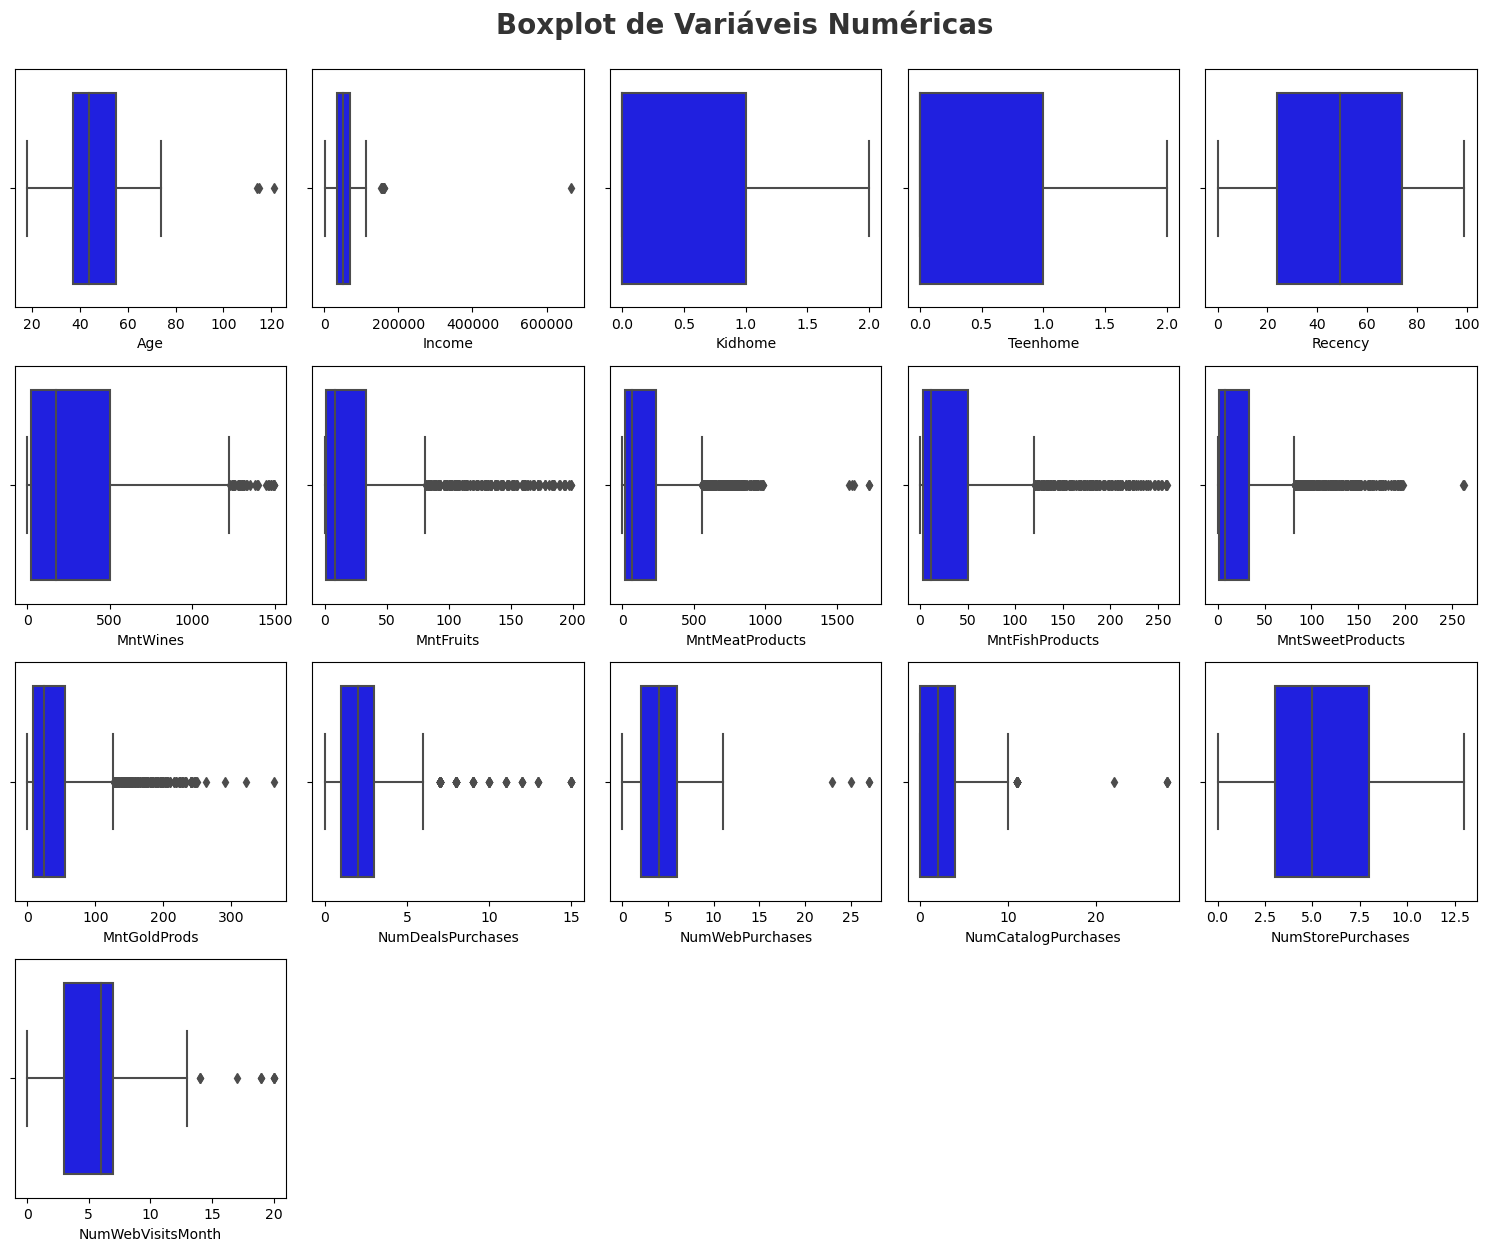

In [114]:
numeric_features = ['Age', 'Income', 'Kidhome',
       'Teenhome', 'Recency', 'MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts', 'MntGoldProds',
                    'NumDealsPurchases','NumWebPurchases' ,'NumCatalogPurchases' ,'NumStorePurchases','NumWebVisitsMonth']       

plt.figure(figsize=(15,15))

plt.suptitle("Boxplot de Variáveis Numéricas", fontsize=20, fontweight='bold', alpha=0.8, y=1.)

for i in range(len(numeric_features)):
    
    plt.subplot(5, 5, i+1)  
    
    sns.boxplot(x=df[numeric_features[i]], color='b')
    
    plt.xlabel(numeric_features[i])
    
    plt.tight_layout()

Alguns insights obtidos:

- Alguns clintes possuem mais de 100 anos. É possível mas bem improvável.
- Como identificado anteriormente, a variável "Income" possui um outlier muito discrepante do restante da vaga. Pode ser algum erro de digitação.

Primeiramente irei identificar quais clientes estão com indicação de idade maior que 100 e irei excluí-los da base, visto que nesse caso não é possível consultar a área de negócio para entender se esse valores estão corretos.

In [115]:
display(df[df['Age']> 100])

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Age
192,7829,1900,2n Cycle,Divorced,36640.0,1,0,2013-09-26,99,15,...,0,0,0,0,0,1,3,11,0,114
239,11004,1893,2n Cycle,Single,60182.0,0,1,2014-05-17,23,8,...,0,0,0,0,0,0,3,11,0,121
339,1150,1899,PhD,Together,83532.0,0,0,2013-09-26,36,755,...,0,0,1,0,0,0,3,11,0,115


In [116]:
# Encontrando os índices das linhas que a idade seja maior que 100
linha = df[df['Age']>100].index

#Removendo essa linhas do dataframe
df=df.drop(linha)


Segundo, como identifique na coluna "Income" alguns valores maiores que o máximo apresentado pelo Boxplot irei investigar essas linhas.

In [117]:
display(df[df['Income']> 150000])

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Age
164,8475,1973,PhD,Married,157243.0,0,1,2014-03-01,98,20,...,0,0,0,0,0,0,3,11,0,41
617,1503,1976,PhD,Together,162397.0,1,1,2013-06-03,31,85,...,0,0,0,0,0,0,3,11,0,38
655,5555,1975,Graduation,Divorced,153924.0,0,0,2014-02-07,81,1,...,0,0,0,0,0,0,3,11,0,39
687,1501,1982,PhD,Married,160803.0,0,0,2012-08-04,21,55,...,0,0,0,0,0,0,3,11,0,32
1300,5336,1971,Master,Together,157733.0,1,0,2013-06-04,37,39,...,0,0,0,0,0,0,3,11,0,43
1653,4931,1977,Graduation,Together,157146.0,0,0,2013-04-29,13,1,...,0,0,0,0,0,0,3,11,0,37
2132,11181,1949,PhD,Married,156924.0,0,0,2013-08-29,85,2,...,0,0,0,0,0,0,3,11,0,65
2233,9432,1977,Graduation,Together,666666.0,1,0,2013-06-02,23,9,...,0,0,0,0,0,0,3,11,0,37


O cliente com ID 9432 apresenta um Income muito acima de toda a base, considerarei como outlier e retirarei da base usando como regra o "Income" seno maior que 200.000

In [118]:
# Encontrando os índices das linhas que a renda seja maior que 200.000
linha = df[df['Income']> 200000].index

#Removendo essa linhas do dataframe
df=df.drop(linha)


No início da análise, identifiquei que a coluna "Income" era a única que apresenta valores nulos e para isso irei identificar todas as linhas com essa condição.

In [86]:
display(df[df['Income'].isnull()])

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Age
10,1994,1983,Graduation,Married,NaN,1,0,2013-11-15,11,5,...,0,0,0,0,0,0,3,11,0,31
27,5255,1986,Graduation,Single,NaN,1,0,2013-02-20,19,5,...,0,0,0,0,0,0,3,11,0,28
43,7281,1959,PhD,Single,NaN,0,0,2013-11-05,80,81,...,0,0,0,0,0,0,3,11,0,55
48,7244,1951,Graduation,Single,NaN,2,1,2014-01-01,96,48,...,0,0,0,0,0,0,3,11,0,63
58,8557,1982,Graduation,Single,NaN,1,0,2013-06-17,57,11,...,0,0,0,0,0,0,3,11,0,32
71,10629,1973,2n Cycle,Married,NaN,1,0,2012-09-14,25,25,...,0,0,0,0,0,0,3,11,0,41
90,8996,1957,PhD,Married,NaN,2,1,2012-11-19,4,230,...,0,0,0,0,0,0,3,11,0,57
91,9235,1957,Graduation,Single,NaN,1,1,2014-05-27,45,7,...,0,0,0,0,0,0,3,11,0,57
92,5798,1973,Master,Together,NaN,0,0,2013-11-23,87,445,...,0,0,0,0,0,0,3,11,0,41
128,8268,1961,PhD,Married,NaN,0,1,2013-07-11,23,352,...,0,0,0,0,0,0,3,11,0,53


Apesar da coluna "Income" ter pouco valores nulos em comparação com o tamanho da base e não tem como consultar a área de negócio, não irei retira-los. Escolhi substituir esses valores nulos pela mediana na coluna, pois ela sofre menor influência de outliers se comparado com a média.

In [119]:
for column in ['Income']:
    df[column].fillna(df[column].mean(), inplace=True)

Irei plotar novamente o Boxplot, agora com as alterações feitas.

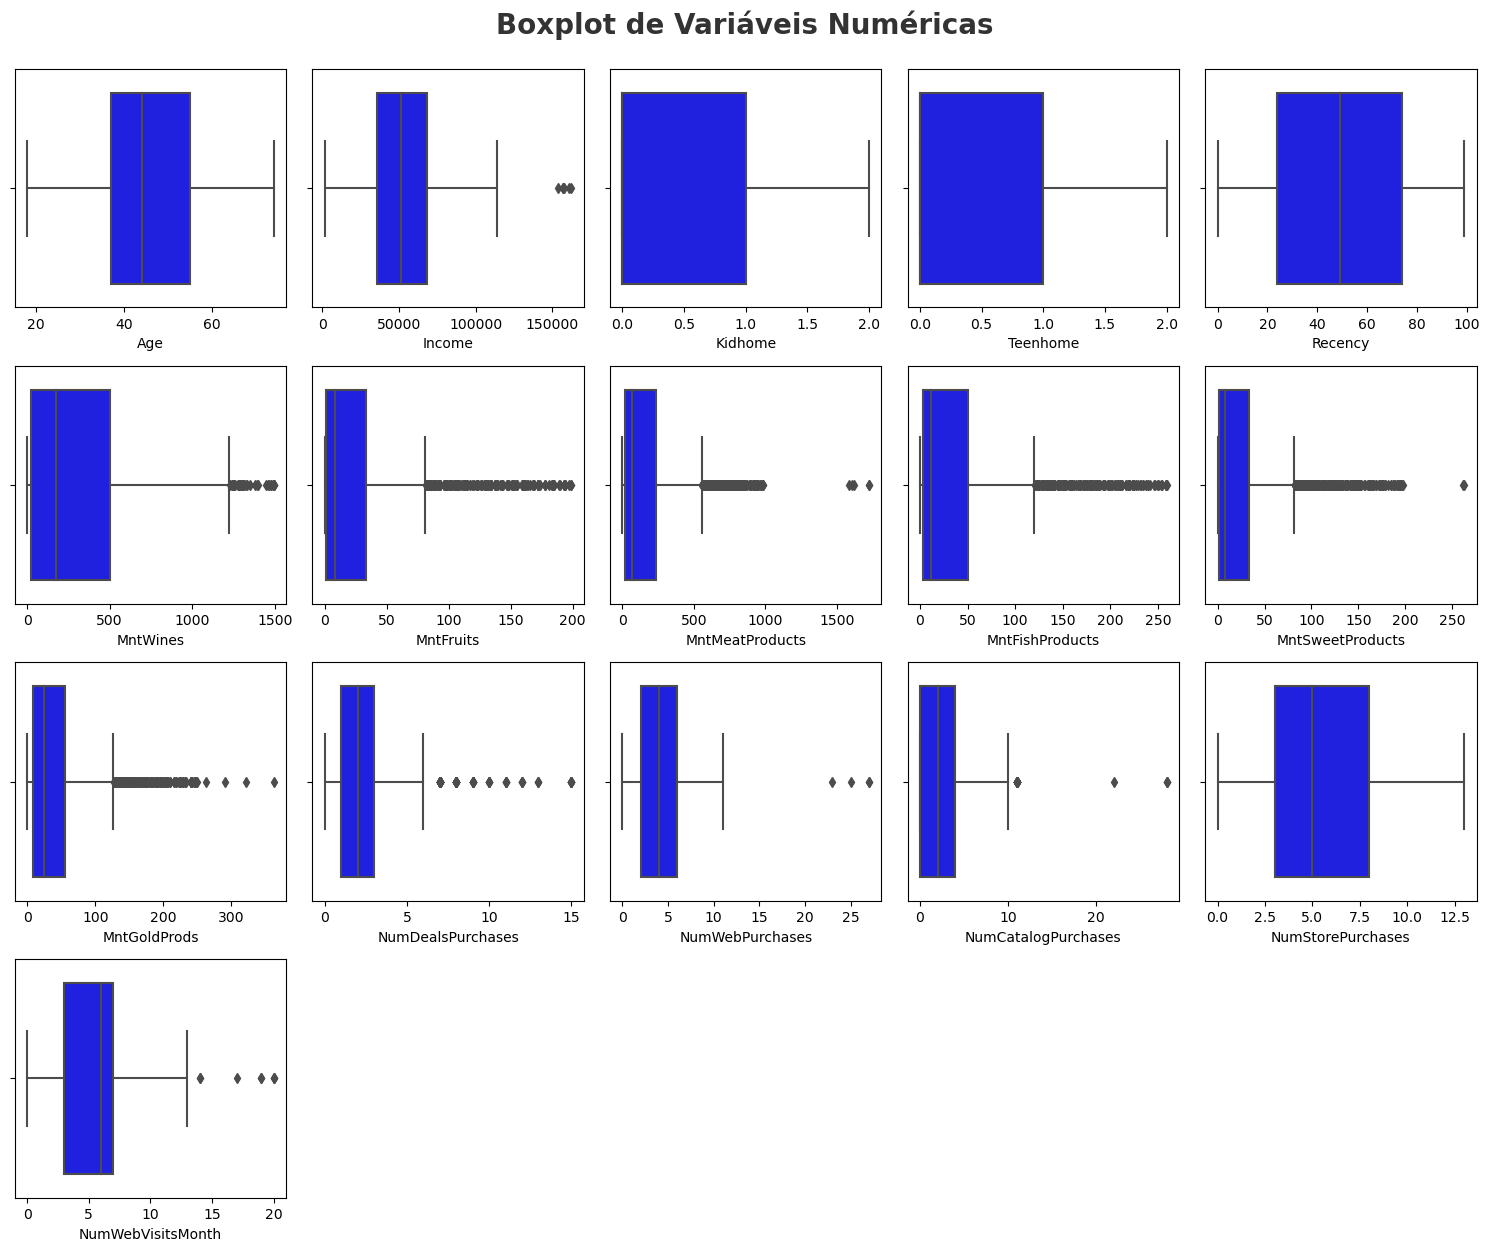

In [120]:
numeric_features = ['Age', 'Income', 'Kidhome',
       'Teenhome', 'Recency', 'MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts', 'MntGoldProds',
                    'NumDealsPurchases','NumWebPurchases' ,'NumCatalogPurchases' ,'NumStorePurchases','NumWebVisitsMonth']       

plt.figure(figsize=(15,15))

plt.suptitle("Boxplot de Variáveis Numéricas", fontsize=20, fontweight='bold', alpha=0.8, y=1.)

for i in range(len(numeric_features)):
    
    plt.subplot(5, 5, i+1)  
    
    sns.boxplot(x=df[numeric_features[i]], color='b')
    
    plt.xlabel(numeric_features[i])
    
    plt.tight_layout()

Irei verificar a quantidade e porcentagem de clientes que participaram para cada número de campanha.

In [121]:
resultado, df_colunas_utilizadas, colunas_utilizadas = criar_coluna_binaria(df)

# Obter contagem de valores
contagem_valores = resultado['AcceptedCmpTotal'].value_counts()

# Calcular porcentagem para cada valor
porcentagens = (contagem_valores / contagem_valores.sum()) * 100

# Exibir contagem e porcentagem para cada valor
for valor, contagem in contagem_valores.items():
    porcentagem = porcentagens[valor]
    print(f"Qtd de Campanhas: {valor}, Contagem: {contagem}, Porcentagem: {porcentagem:.2f}%")

Qtd de Campanhas: 0, Contagem: 1774, Porcentagem: 79.34%
Qtd de Campanhas: 1, Contagem: 324, Porcentagem: 14.49%
Qtd de Campanhas: 2, Contagem: 83, Porcentagem: 3.71%
Qtd de Campanhas: 3, Contagem: 44, Porcentagem: 1.97%
Qtd de Campanhas: 4, Contagem: 11, Porcentagem: 0.49%


Isso nos permite analisar que nenhum cliente participou de todas as 5 campanhas e que a grande maioria não tem sido adepto.

Irei analisar como tem sido a taxa de conversão de cada campanha.

In [122]:
for i in range(1, 6):
    taxa_conversao = round(resultado[f'AcceptedCmp{i}'].sum() / len(df) * 100, 2)
    print(f"Taxa de Conversão da Campanha {i}: {taxa_conversao}%")

Taxa de Conversão da Campanha 1: 6.44%
Taxa de Conversão da Campanha 2: 1.34%
Taxa de Conversão da Campanha 3: 7.29%
Taxa de Conversão da Campanha 4: 7.47%
Taxa de Conversão da Campanha 5: 7.25%


Nota-se que a segunda campanha teve uma taxa de conversão bem abaixo das demais. Vale estudar para entender qual foi a diferença entre elas.

Buscarei entender agora como foi o grau de retenção de uma campanha para a outra, ou seja, se clientes que participaram de uma acampanha foram adeptos da seguinte.

In [123]:
for i in range(1, 5):
    # Conta o número de clientes que participaram das duas campanhas consecutivas
    count_retidos = len(df[(df[f'AcceptedCmp{i}'] == 1) & (df[f'AcceptedCmp{i+1}'] == 1)])
    
    taxa_retencao = round(count_retidos / len(df) * 100, 2)
    
    print(f"Taxa de retenção da campanha {i} para campanha {i+1}: {taxa_retencao}% e total {count_retidos}")

Taxa de retenção da campanha 1 para campanha 2: 0.58% e total 13
Taxa de retenção da campanha 2 para campanha 3: 0.31% e total 7
Taxa de retenção da campanha 3 para campanha 4: 0.0% e total 0
Taxa de retenção da campanha 4 para campanha 5: 2.64% e total 59


É possível notar que nenhum dos clientes que participaram da campanha 3 participou da 4. Será que houve alguma alteração do que foi feito que não foi bem recebida?

Por outro lado, é possível perceber que durante os períodos de campanhas, a transição da quarta para a quinta tenha sido a que apresentou o maior índice de retenção

Irei remover as colunas ZCostContact e ZRevenue, pois identifiquei que elas são constantes e não servirão para as análises que serão feitas.

Será removido também a coluna de Year_Birth visto que já criamos uma coluna de inteiros para a idade.


In [124]:
colunas = ['Z_CostContact', 'Z_Revenue', 'Year_Birth', 'Dt_Customer', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3',
           'AcceptedCmp4', 'AcceptedCmp5', 'Complain', 'Response', 'ID', 'AcceptedCmpTotal']
df = df.drop(columns=colunas)

### ANÁLISE EXPLORATÓRIA (EDA) UNIVARIADA

- **Variáveis Categóricas:** 


Para analisar os dados das variáveis categóricas, irei plotar os valores em um gráfico de barras para entender quais categorias estão presentes nos dados da base.

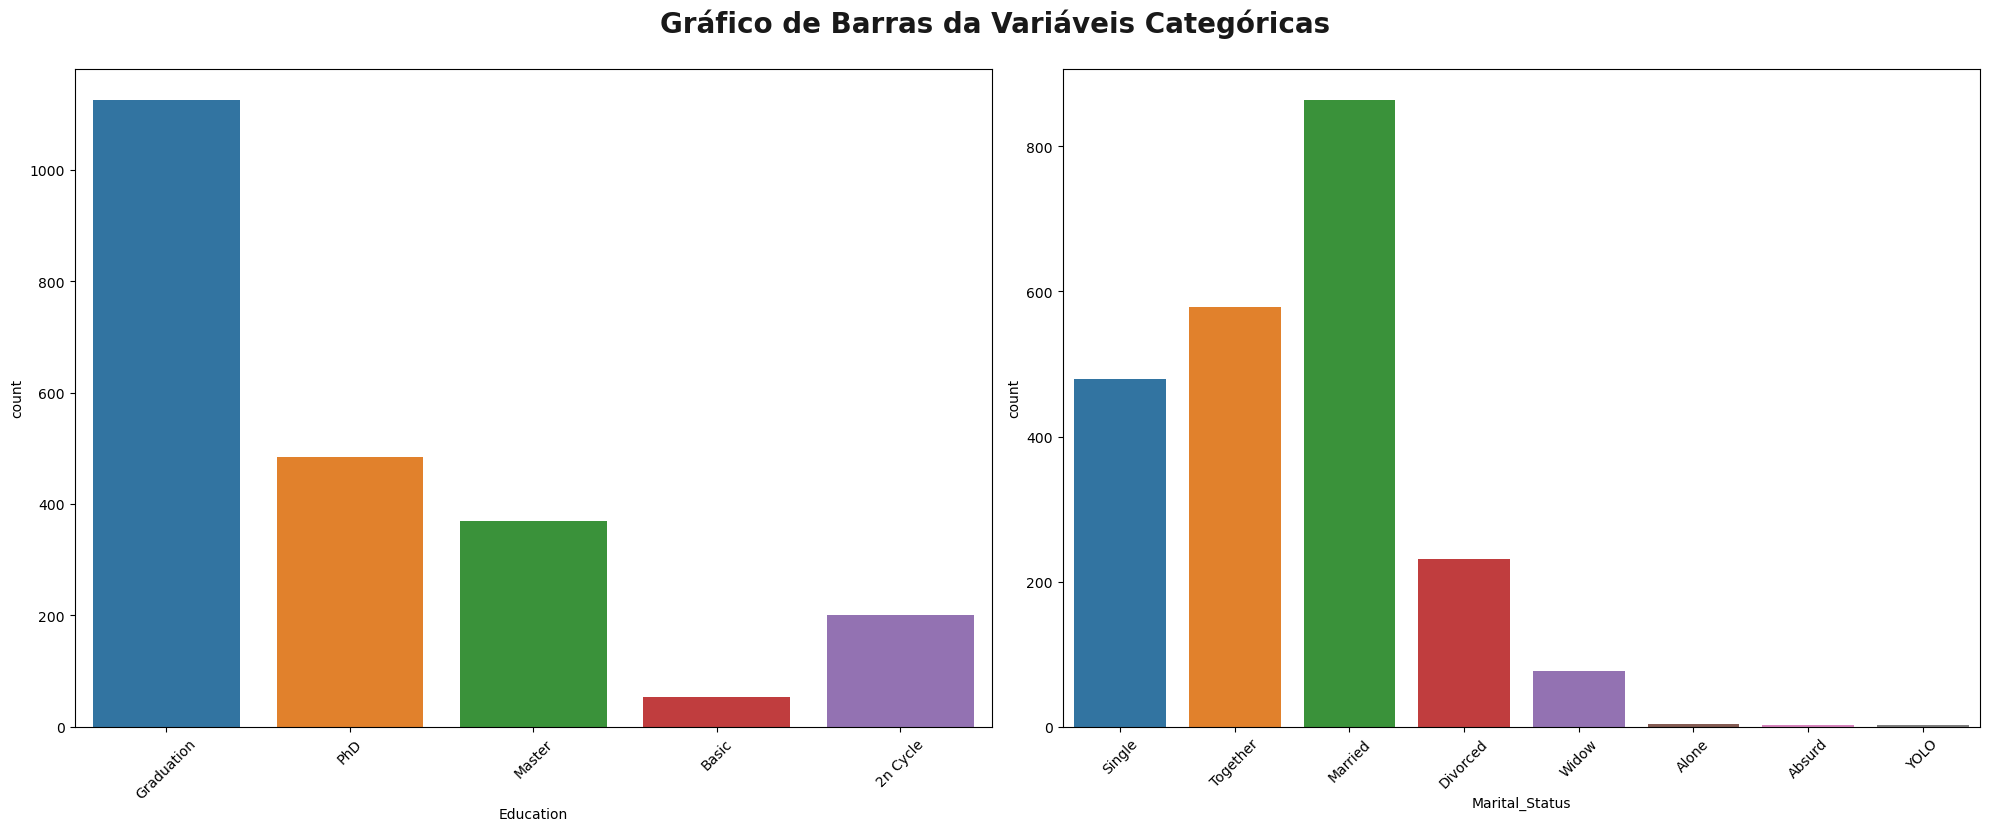

In [125]:
warnings.filterwarnings('ignore')

plt.figure(figsize=(20,15))

plt.suptitle("Gráfico de Barras da Variáveis Categóricas", fontsize=20, fontweight='bold', alpha=0.9, y=1.)

cat1=['Education', 'Marital_Status']

for i in range(len(cat1)):

    plt.subplot(2,2,i+1)

    sns.countplot(x=df[cat1[i]])

    plt.xlabel(cat1[i])

    plt.xticks(rotation=45)

    plt.tight_layout()

Podemos reparar que a coluna de Marital_Status apresentam diferentes categorias que são parecidas e para afim de análise irei juntar elas.

In [126]:
df["Marital_Status"] = df["Marital_Status"].replace(
    {
        "Alone": "Single",
        "Absurd": "Single",
        "YOLO": "Single",
        "Together": "Partner",
        "Married": "Partner",
        "Divorced": "Single",
        "Widow": "Single",
        "Single": "Single"
    })

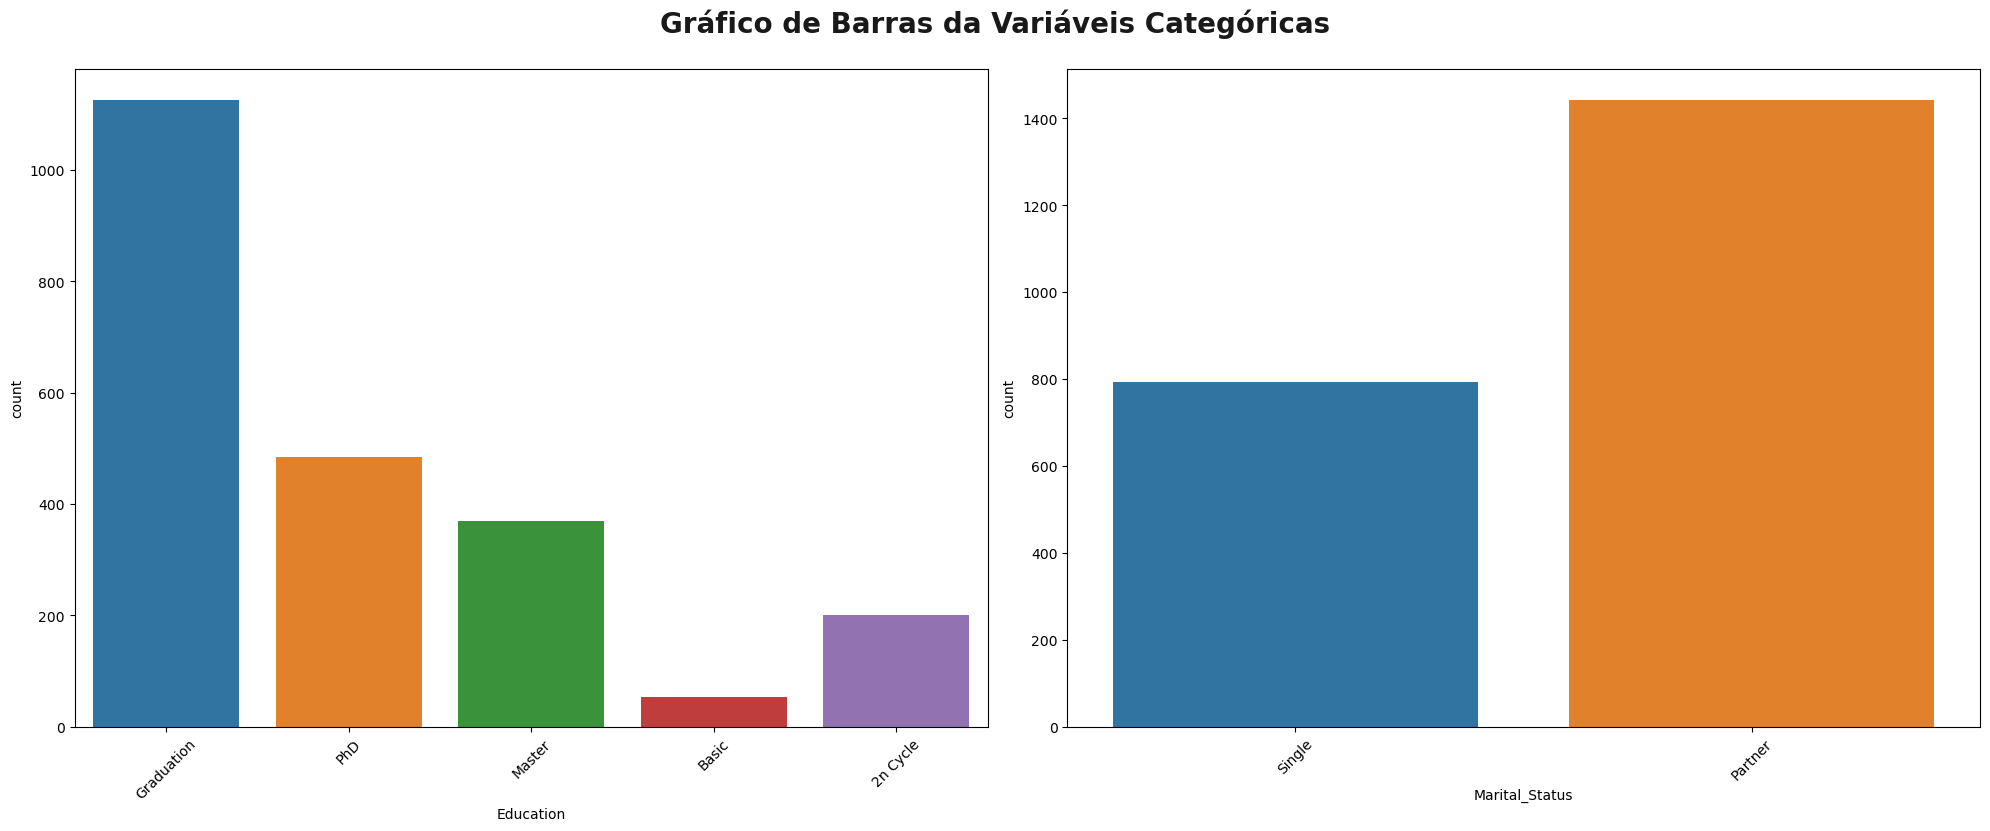

In [127]:
warnings.filterwarnings('ignore')

plt.figure(figsize=(20,15))

plt.suptitle("Gráfico de Barras da Variáveis Categóricas", fontsize=20, fontweight='bold', alpha=0.9, y=1.)

cat1=['Education', 'Marital_Status']

for i in range(len(cat1)):

    plt.subplot(2,2,i+1)

    sns.countplot(x=df[cat1[i]])

    plt.xlabel(cat1[i])

    plt.xticks(rotation=45)

    plt.tight_layout()

### ANÁLISE EXPLORATÓRIA (EDA) BIVARIADA

Irei criar uma tabela de correlação para entender essa relação entre as variáveis quantitativas.

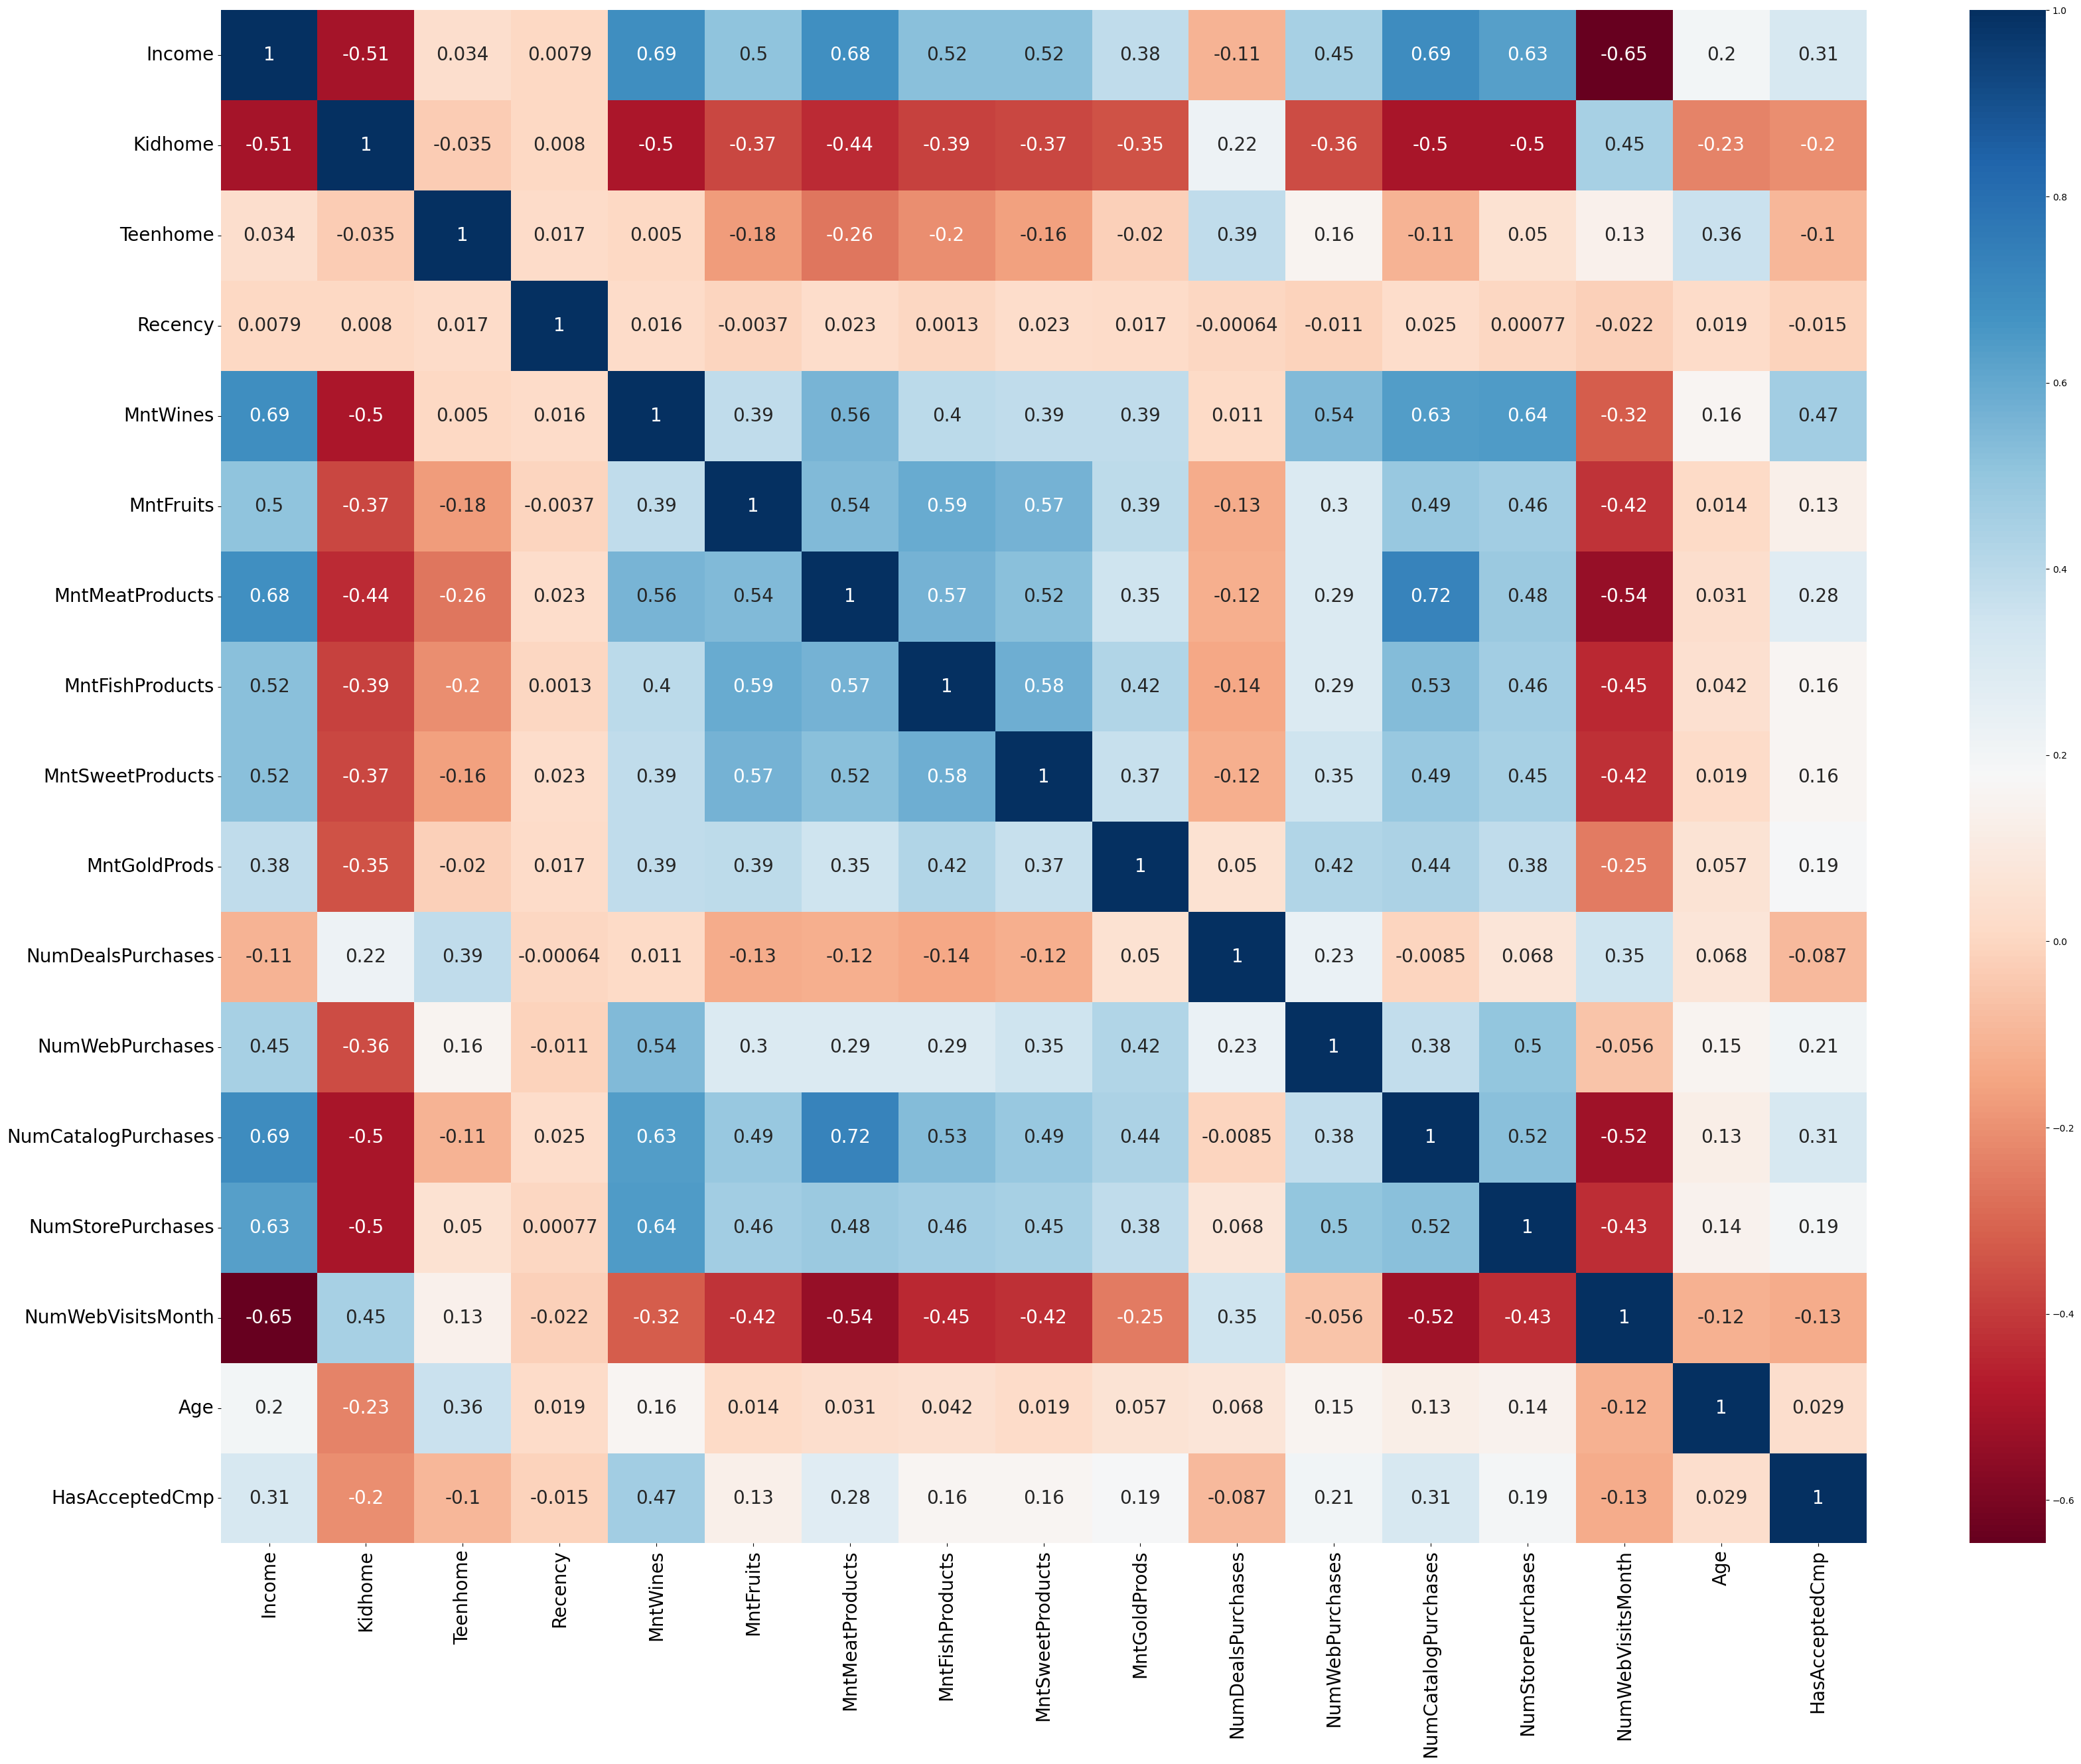

In [96]:
plt.figure(figsize=(40,30))

heatmap = sns.heatmap(df.corr(), annot = True, cmap="RdBu", annot_kws={"size": 20})

heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=20)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=20)

plt.show()

Podemos notar alguns pontos através dessa tabela:

- A variável "Income" possui uma alta correlação com a "NumWebVisitsMonth", ou seja, quanto maior a renda menor é a quantidade de visitas no site. Isso pode indicar que quanto maior a renda menor é a necessidade de ficar consultando os preços;

- A variável "MntMeatProduct" tem uma alta relação positiva com as variáveis "Income" e "NumCatalogPurchases" o que indica que clientes com maires rendas tendem a consumir mais carne e que as compras desse tipo tendem ser mais em catálogos.

Utilizarei a função auxiliar tabela_de_frequencia para poder criar tabelas desse tipo para cada variável.

In [97]:
final = {}
for col in df.columns:
    final[col] = tabela_de_frequencia(df, col)


for coluna, tabela in final.items():
    display(tabela)

,Education,Frequência Absoluta,Frequência Relativa,Frequência Acumulada
0,2n Cycle,201,8.99,8.99
1,Basic,54,2.42,11.41
2,Graduation,1126,50.36,61.77
3,Master,370,16.55,78.32
4,PhD,485,21.69,100.01
5,Total,2236,100.00,100.00


,Marital_Status,Frequência Absoluta,Frequência Relativa,Frequência Acumulada
0,Partner,1442,64.49,64.49
1,Single,794,35.51,100.00
2,Total,2236,100.00,100.00


,Income,Frequência Absoluta,Frequência Relativa,Frequência Acumulada
0,1730 - 17797,90,4.03,4.03
1,17797 - 33863,410,18.34,22.37
2,33863 - 49930,557,24.91,47.28
3,49930 - 65997,551,24.64,71.92
4,65997 - 82064,472,21.11,93.03
5,82064 - 98130,142,6.35,99.38
6,146330 - 162558,7,0.31,100.00
7,Total,2236,100.00,100.00


,Kidhome,Frequência Absoluta,Frequência Relativa,Frequência Acumulada
0,0,1291,57.74,57.74
1,1,897,40.12,97.86
2,2,48,2.15,100.01
3,Total,2236,100.00,100.00


,Teenhome,Frequência Absoluta,Frequência Relativa,Frequência Acumulada
0,0,1155,51.65,51.65
1,1,1029,46.02,97.67
2,2,52,2.33,100.00
3,Total,2236,100.00,100.00


,Recency,Frequência Absoluta,Frequência Relativa,Frequência Acumulada
0,0 - 10,233,10.42,10.42
1,10 - 20,223,9.97,20.39
2,20 - 30,234,10.47,30.86
3,30 - 40,213,9.53,40.39
4,40 - 50,216,9.66,50.05
5,50 - 59,234,10.47,60.52
6,59 - 69,213,9.53,70.05
7,69 - 79,224,10.02,80.07
8,79 - 89,229,10.24,90.31
9,89 - 99,217,9.70,100.01


,MntWines,Frequência Absoluta,Frequência Relativa,Frequência Acumulada
0,0 - 149,1042,46.60,46.60
1,149 - 299,325,14.53,61.13
2,299 - 448,232,10.38,71.51
3,448 - 597,210,9.39,80.90
4,597 - 746,142,6.35,87.25
5,746 - 896,98,4.38,91.63
6,896 - 1045,98,4.38,96.01
7,1045 - 1194,45,2.01,98.02
8,1194 - 1344,31,1.39,99.41
9,1344 - 1494,13,0.58,99.99


,MntFruits,Frequência Absoluta,Frequência Relativa,Frequência Acumulada
0,0 - 20,1466,65.56,65.56
1,20 - 40,283,12.66,78.22
2,40 - 60,145,6.48,84.70
3,60 - 80,95,4.25,88.95
4,80 - 100,75,3.35,92.30
5,100 - 119,53,2.37,94.67
6,119 - 139,48,2.15,96.82
7,139 - 159,27,1.21,98.03
8,159 - 179,27,1.21,99.24
9,179 - 199,17,0.76,100.00


,MntMeatProducts,Frequência Absoluta,Frequência Relativa,Frequência Acumulada
0,0 - 172,1559,69.72,69.72
1,172 - 345,274,12.25,81.97
2,345 - 518,195,8.72,90.69
3,518 - 690,99,4.43,95.12
4,690 - 862,78,3.49,98.61
5,862 - 1035,26,1.16,99.77
6,1552 - 1727,5,0.22,99.99
7,Total,2236,100.00,100.00


,MntFishProducts,Frequência Absoluta,Frequência Relativa,Frequência Acumulada
0,0 - 26,1437,64.27,64.27
1,26 - 52,255,11.40,75.67
2,52 - 78,160,7.16,82.83
3,78 - 104,106,4.74,87.57
4,104 - 130,73,3.26,90.83
5,130 - 155,68,3.04,93.87
6,155 - 181,51,2.28,96.15
7,181 - 207,36,1.61,97.76
8,207 - 233,32,1.43,99.19
9,233 - 259,18,0.81,100.00


,MntSweetProducts,Frequência Absoluta,Frequência Relativa,Frequência Acumulada
0,0 - 26,1585,70.89,70.89
1,26 - 53,260,11.63,82.52
2,53 - 79,131,5.86,88.38
3,79 - 105,96,4.29,92.67
4,105 - 132,59,2.64,95.31
5,132 - 158,55,2.46,97.77
6,158 - 184,31,1.39,99.16
7,184 - 210,17,0.76,99.92
8,237 - 263,2,0.09,100.01
9,Total,2236,100.00,100.00


,MntGoldProds,Frequência Absoluta,Frequência Relativa,Frequência Acumulada
0,0 - 36,1394,62.34,62.34
1,36 - 72,391,17.49,79.83
2,72 - 109,188,8.41,88.24
3,109 - 145,106,4.74,92.98
4,145 - 181,77,3.44,96.42
5,181 - 217,48,2.15,98.57
6,217 - 253,28,1.25,99.82
7,326 - 362,1,0.04,99.99
8,Total,2236,100.00,100.00


,NumDealsPurchases,Frequência Absoluta,Frequência Relativa,Frequência Acumulada
0,0 - 5,1995,89.22,89.22
1,5 - 10,217,9.70,98.92
2,10 - 15,24,1.07,99.99
3,Total,2236,100.00,100.00


,NumWebPurchases,Frequência Absoluta,Frequência Relativa,Frequência Acumulada
0,0 - 9,2070,92.58,92.58
1,9 - 18,162,7.25,99.83
2,18 - 27,4,0.18,100.01
3,Total,2236,100.00,100.00


,NumCatalogPurchases,Frequência Absoluta,Frequência Relativa,Frequência Acumulada
0,0 - 9,2165,96.82,96.82
1,9 - 19,67,3.00,99.82
2,19 - 28,4,0.18,100.00
3,Total,2236,100.00,100.00


,NumStorePurchases,Frequência Absoluta,Frequência Relativa,Frequência Acumulada
0,0 - 4,1054,47.14,47.14
1,4 - 9,682,30.50,77.64
2,9 - 13,500,22.36,100.00
3,Total,2236,100.00,100.00


,NumWebVisitsMonth,Frequência Absoluta,Frequência Relativa,Frequência Acumulada
0,0 - 5,787,35.20,35.20
1,5 - 10,1437,64.27,99.47
2,15 - 20,6,0.27,100.01
3,Total,2236,100.00,100.00


,Age,Frequência Absoluta,Frequência Relativa,Frequência Acumulada
0,18 - 26,91,4.07,4.07
1,26 - 34,294,13.15,17.22
2,34 - 42,535,23.93,41.15
3,42 - 50,533,23.84,64.99
4,50 - 58,363,16.23,81.22
5,58 - 66,343,15.34,96.56
6,66 - 74,77,3.44,100.00
7,Total,2236,100.00,100.00


,HasAcceptedCmp,Frequência Absoluta,Frequência Relativa,Frequência Acumulada
0,0,1774,79.34,79.34
1,1,462,20.66,100.00
2,Total,2236,100.00,100.00


Pontos observados:
- Os clientes com escolaridade “Graduation” compõem mais da metade da base com 50,36%;
- Clientes que estão com status matrimonial de “Partner” são a maioria com 64,49%;
- Mais de 80% dos cientes possuem renda entre 33.863 e 82.064;
- Clientes que não possuem criança em casa são maioria na base com 57,74%;
- Clientes que não possuem adolescentes em casa também são a maioria com 51,65%
- Há uma distribuição bem uniforme nos dias desde a última compra entre os clientes;
- Quase metade dos clientes tem um gasto baixo com vinho, 46,6% gastam até R$ 149;
- Assim como os demais gastos;
- Quase 90% fizeram poucas compras com desconto, até 5 compras;
- Assim como as demais compras;
- Mais de 60% visitaram o site entre 5 e 10 vezes por mês;
- Quase metade dos clientes possuem idade entre 34 e 50 anos;
- E como visto anteriormente, a grande maioria (79,34%) não aceitaram de alguma campanha.


Farei as tabelas de cálculo do Information Value de cada variável para entender o poder de separação da variável binária (se participaram de alguma campanha 1 ou não 0) utilizando a função auxiliar criada iv_woe.

In [98]:
# Chame a função para calcular o IV para todas as variáveis do DataFrame
iv = iv_woe(df=df, target='HasAcceptedCmp', colunas=df.columns, bins=10, show_woe=True)

# Exiba os resultados
exibir_resultados(iv)

Resultados para a variável 'Education':


,Variavel,Total Linha,Eventos,% de Eventos,Não Eventos,% de Não Eventos,Taxa de Aceitação,WOE,IV
0,2n Cycle,201.0,38.0,8.23,163.0,9.19,18.91,-0.11,0.001056
1,Basic,54.0,6.0,1.30,48.0,2.71,11.11,-0.73,0.010293
2,Graduation,1126.0,230.0,49.78,896.0,50.51,20.43,-0.01,0.000073
3,Master,370.0,75.0,16.23,295.0,16.63,20.27,-0.02,0.000080
4,PhD,485.0,113.0,24.46,372.0,20.97,23.30,0.15,0.005235
5,Total Geral,2236.0,462.0,100.00,1774.0,100.00,20.66,0.00,0.016737


Resultados para a variável 'Marital_Status':


,Variavel,Total Linha,Eventos,% de Eventos,Não Eventos,% de Não Eventos,Taxa de Aceitação,WOE,IV
0,Partner,1442.0,297.0,64.29,1145.0,64.54,20.60,-0.00,0.000000
1,Single,794.0,165.0,35.71,629.0,35.46,20.78,0.01,0.000025
2,Total Geral,2236.0,462.0,100.00,1774.0,100.00,20.66,0.00,0.000025


Resultados para a variável 'Income':


,Variavel,Total Linha,Eventos,% de Eventos,Não Eventos,% de Não Eventos,Taxa de Aceitação,WOE,IV
0,"(1729.999, 24213.5]",224.0,17.0,3.68,207.0,11.67,7.59,-1.15,0.091885
1,"(24213.5, 32218.0]",224.0,18.0,3.90,206.0,11.61,8.04,-1.09,0.084039
2,"(32218.0, 38361.0]",224.0,25.0,5.41,199.0,11.22,11.16,-0.73,0.042413
3,"(38361.0, 44931.0]",223.0,22.0,4.76,201.0,11.33,9.87,-0.87,0.057159
4,"(44931.0, 51684.0]",223.0,35.0,7.58,188.0,10.60,15.70,-0.34,0.010268
5,"(51684.0, 58116.0]",224.0,45.0,9.74,179.0,10.09,20.09,-0.04,0.000140
6,"(58116.0, 65104.0]",224.0,43.0,9.31,181.0,10.20,19.20,-0.09,0.000801
7,"(65104.0, 71613.0]",223.0,39.0,8.44,184.0,10.37,17.49,-0.21,0.004053
8,"(71613.0, 79747.5]",223.0,85.0,18.40,138.0,7.78,38.12,0.86,0.091332
9,"(79747.5, 162397.0]",224.0,133.0,28.79,91.0,5.13,59.38,1.72,0.406952


Resultados para a variável 'Kidhome':


,Variavel,Total Linha,Eventos,% de Eventos,Não Eventos,% de Não Eventos,Taxa de Aceitação,WOE,IV
0,0,1291.0,359.0,77.71,932.0,52.54,27.81,0.39,0.098163
1,1,897.0,100.0,21.65,797.0,44.93,11.15,-0.73,0.169944
2,2,48.0,3.0,0.65,45.0,2.54,6.25,-1.36,0.025704
3,Total Geral,2236.0,462.0,100.00,1774.0,100.00,20.66,0.00,0.293811


Resultados para a variável 'Teenhome':


,Variavel,Total Linha,Eventos,% de Eventos,Não Eventos,% de Não Eventos,Taxa de Aceitação,WOE,IV
0,0,1155.0,288.0,62.34,867.0,48.87,24.94,0.24,0.032328
1,1,1029.0,163.0,35.28,866.0,48.82,15.84,-0.32,0.043328
2,2,52.0,11.0,2.38,41.0,2.31,21.15,0.03,0.000021
3,Total Geral,2236.0,462.0,100.00,1774.0,100.00,20.66,0.00,0.075677


Resultados para a variável 'Recency':


,Variavel,Total Linha,Eventos,% de Eventos,Não Eventos,% de Não Eventos,Taxa de Aceitação,WOE,IV
0,"(-0.001, 9.0]",233.0,45.0,9.74,188.0,10.60,19.31,-0.08,0.000688
1,"(9.0, 19.0]",223.0,48.0,10.39,175.0,9.86,21.52,0.05,0.000265
2,"(19.0, 29.0]",234.0,58.0,12.55,176.0,9.92,24.79,0.24,0.006312
3,"(29.0, 39.0]",213.0,49.0,10.61,164.0,9.24,23.00,0.14,0.001918
4,"(39.0, 49.0]",216.0,37.0,8.01,179.0,10.09,17.13,-0.23,0.004784
5,"(49.0, 59.0]",234.0,43.0,9.31,191.0,10.77,18.38,-0.15,0.002190
6,"(59.0, 69.0]",213.0,50.0,10.82,163.0,9.19,23.47,0.16,0.002608
7,"(69.0, 79.0]",224.0,45.0,9.74,179.0,10.09,20.09,-0.04,0.000140
8,"(79.0, 89.0]",229.0,43.0,9.31,186.0,10.48,18.78,-0.12,0.001404
9,"(89.0, 99.0]",217.0,44.0,9.52,173.0,9.75,20.28,-0.02,0.000046


Resultados para a variável 'MntWines':


,Variavel,Total Linha,Eventos,% de Eventos,Não Eventos,% de Não Eventos,Taxa de Aceitação,WOE,IV
0,"(-0.001, 6.0]",232.0,18.0,3.90,214.0,12.06,7.76,-1.13,0.092208
1,"(6.0, 16.0]",226.0,20.0,4.33,206.0,11.61,8.85,-0.99,0.072072
2,"(16.0, 34.0]",219.0,11.0,2.38,208.0,11.72,5.02,-1.59,0.148506
3,"(34.0, 82.0]",218.0,15.0,3.25,203.0,11.44,6.88,-1.26,0.103194
4,"(82.0, 174.0]",224.0,32.0,6.93,192.0,10.82,14.29,-0.45,0.017505
5,"(174.0, 285.0]",223.0,19.0,4.11,204.0,11.50,8.52,-1.03,0.076117
6,"(285.0, 419.0]",223.0,45.0,9.74,178.0,10.03,20.18,-0.03,0.000087
7,"(419.0, 581.0]",224.0,69.0,14.94,155.0,8.74,30.80,0.54,0.033480
8,"(581.0, 822.5]",223.0,79.0,17.10,144.0,8.12,35.43,0.74,0.066452
9,"(822.5, 1493.0]",224.0,154.0,33.33,70.0,3.95,68.75,2.13,0.625794


Resultados para a variável 'MntFruits':


,Variavel,Total Linha,Eventos,% de Eventos,Não Eventos,% de Não Eventos,Taxa de Aceitação,WOE,IV
0,"(-0.001, 1.0]",561.0,95.0,20.56,466.0,26.27,16.93,-0.25,0.014275
1,"(1.0, 2.0]",120.0,12.0,2.60,108.0,6.09,10.00,-0.85,0.029665
2,"(2.0, 4.0]",220.0,21.0,4.55,199.0,11.22,9.55,-0.90,0.060030
3,"(4.0, 8.0]",241.0,39.0,8.44,202.0,11.39,16.18,-0.30,0.008850
4,"(8.0, 15.0]",224.0,33.0,7.14,191.0,10.77,14.73,-0.41,0.014883
5,"(15.0, 25.0]",208.0,70.0,15.15,138.0,7.78,33.65,0.67,0.049379
6,"(25.0, 44.0]",223.0,68.0,14.72,155.0,8.74,30.49,0.52,0.031096
7,"(44.0, 82.5]",215.0,57.0,12.34,158.0,8.91,26.51,0.33,0.011319
8,"(82.5, 199.0]",224.0,67.0,14.50,157.0,8.85,29.91,0.49,0.027685
9,Total Geral,2236.0,462.0,100.00,1774.0,100.00,20.66,0.00,0.247182


Resultados para a variável 'MntMeatProducts':


,Variavel,Total Linha,Eventos,% de Eventos,Não Eventos,% de Não Eventos,Taxa de Aceitação,WOE,IV
0,"(-0.001, 7.0]",260.0,19.0,4.11,241.0,13.59,7.31,-1.20,0.113760
1,"(7.0, 12.0]",207.0,27.0,5.84,180.0,10.15,13.04,-0.55,0.023705
2,"(12.0, 20.0]",211.0,15.0,3.25,196.0,11.05,7.11,-1.22,0.095160
3,"(20.0, 35.0]",217.0,34.0,7.36,183.0,10.32,15.67,-0.34,0.010064
4,"(35.0, 67.0]",224.0,35.0,7.58,189.0,10.65,15.62,-0.34,0.010438
5,"(67.0, 109.0]",226.0,42.0,9.09,184.0,10.37,18.58,-0.13,0.001664
6,"(109.0, 177.0]",221.0,51.0,11.04,170.0,9.58,23.08,0.14,0.002044
7,"(177.0, 298.0]",223.0,60.0,12.99,163.0,9.19,26.91,0.35,0.013300
8,"(298.0, 498.5]",223.0,70.0,15.15,153.0,8.62,31.39,0.56,0.036568
9,"(498.5, 1725.0]",224.0,109.0,23.59,115.0,6.48,48.66,1.29,0.220719


Resultados para a variável 'MntFishProducts':


,Variavel,Total Linha,Eventos,% de Eventos,Não Eventos,% de Não Eventos,Taxa de Aceitação,WOE,IV
0,"(-0.001, 2.0]",550.0,104.0,22.51,446.0,25.14,18.91,-0.11,0.002893
1,"(2.0, 3.0]",130.0,10.0,2.16,120.0,6.76,7.69,-1.14,0.052440
2,"(3.0, 7.0]",255.0,35.0,7.58,220.0,12.40,13.73,-0.49,0.023618
3,"(7.0, 12.0]",205.0,24.0,5.19,181.0,10.20,11.71,-0.68,0.034068
4,"(12.0, 20.0]",219.0,28.0,6.06,191.0,10.77,12.79,-0.58,0.027318
5,"(20.0, 37.0]",213.0,56.0,12.12,157.0,8.85,26.29,0.31,0.010137
6,"(37.0, 65.0]",218.0,66.0,14.29,152.0,8.57,30.28,0.51,0.029172
7,"(65.0, 120.0]",223.0,62.0,13.42,161.0,9.08,27.80,0.39,0.016926
8,"(120.0, 259.0]",223.0,77.0,16.67,146.0,8.23,34.53,0.71,0.059924
9,Total Geral,2236.0,462.0,100.00,1774.0,100.00,20.66,0.00,0.256496


Resultados para a variável 'MntSweetProducts':


,Variavel,Total Linha,Eventos,% de Eventos,Não Eventos,% de Não Eventos,Taxa de Aceitação,WOE,IV
0,"(-0.001, 1.0]",578.0,111.0,24.03,467.0,26.32,19.20,-0.09,0.002061
1,"(1.0, 2.0]",128.0,14.0,3.03,114.0,6.43,10.94,-0.75,0.025500
2,"(2.0, 5.0]",247.0,23.0,4.98,224.0,12.63,9.31,-0.93,0.071145
3,"(5.0, 8.0]",177.0,20.0,4.33,157.0,8.85,11.30,-0.71,0.032092
4,"(8.0, 14.0]",223.0,39.0,8.44,184.0,10.37,17.49,-0.21,0.004053
5,"(14.0, 26.0]",232.0,49.0,10.61,183.0,10.32,21.12,0.03,0.000087
6,"(26.0, 44.0]",204.0,62.0,13.42,142.0,8.00,30.39,0.52,0.028184
7,"(44.0, 89.0]",227.0,66.0,14.29,161.0,9.08,29.07,0.45,0.023445
8,"(89.0, 263.0]",220.0,78.0,16.88,142.0,8.00,35.45,0.75,0.066600
9,Total Geral,2236.0,462.0,100.00,1774.0,100.00,20.66,0.00,0.253167


Resultados para a variável 'MntGoldProds':


,Variavel,Total Linha,Eventos,% de Eventos,Não Eventos,% de Não Eventos,Taxa de Aceitação,WOE,IV
0,"(-0.001, 3.0]",264.0,19.0,4.11,245.0,13.81,7.20,-1.21,0.117370
1,"(3.0, 6.0]",190.0,13.0,2.81,177.0,9.98,6.84,-1.27,0.091059
2,"(6.0, 11.0]",233.0,24.0,5.19,209.0,11.78,10.30,-0.82,0.054038
3,"(11.0, 17.0]",242.0,34.0,7.36,208.0,11.72,14.05,-0.47,0.020492
4,"(17.0, 24.0]",193.0,44.0,9.52,149.0,8.40,22.80,0.13,0.001456
5,"(24.0, 34.0]",232.0,69.0,14.94,163.0,9.19,29.74,0.49,0.028175
6,"(34.0, 46.0]",215.0,62.0,13.42,153.0,8.62,28.84,0.44,0.021120
7,"(46.0, 73.0]",222.0,57.0,12.34,165.0,9.30,25.68,0.28,0.008512
8,"(73.0, 122.0]",223.0,63.0,13.64,160.0,9.02,28.25,0.41,0.018942
9,"(122.0, 362.0]",222.0,77.0,16.67,145.0,8.17,34.68,0.71,0.060350


Resultados para a variável 'NumDealsPurchases':


,Variavel,Total Linha,Eventos,% de Eventos,Não Eventos,% de Não Eventos,Taxa de Aceitação,WOE,IV
0,"(-0.001, 1.0]",1013.0,271.0,58.66,742.0,41.83,26.75,0.34,0.057222
1,"(1.0, 2.0]",497.0,71.0,15.37,426.0,24.01,14.29,-0.45,0.038880
2,"(2.0, 3.0]",297.0,42.0,9.09,255.0,14.37,14.14,-0.46,0.024288
3,"(3.0, 5.0]",282.0,52.0,11.26,230.0,12.97,18.44,-0.14,0.002394
4,"(5.0, 15.0]",147.0,26.0,5.63,121.0,6.82,17.69,-0.19,0.002261
5,Total Geral,2236.0,462.0,100.00,1774.0,100.00,20.66,0.00,0.125045


Resultados para a variável 'NumWebPurchases':


,Variavel,Total Linha,Eventos,% de Eventos,Não Eventos,% de Não Eventos,Taxa de Aceitação,WOE,IV
0,"(-0.001, 1.0]",402.0,39.0,8.44,363.0,20.46,9.70,-0.89,0.106978
1,"(1.0, 2.0]",372.0,36.0,7.79,336.0,18.94,9.68,-0.89,0.099235
2,"(2.0, 3.0]",335.0,50.0,10.82,285.0,16.07,14.93,-0.40,0.021000
3,"(3.0, 4.0]",279.0,66.0,14.29,213.0,12.01,23.66,0.17,0.003876
4,"(4.0, 5.0]",220.0,72.0,15.58,148.0,8.34,32.73,0.62,0.044888
5,"(5.0, 6.0]",205.0,58.0,12.55,147.0,8.29,28.29,0.41,0.017466
6,"(6.0, 8.0]",257.0,89.0,19.26,168.0,9.47,34.63,0.71,0.069509
7,"(8.0, 27.0]",166.0,52.0,11.26,114.0,6.43,31.33,0.56,0.027048
8,Total Geral,2236.0,462.0,100.00,1774.0,100.00,20.66,0.00,0.390000


Resultados para a variável 'NumCatalogPurchases':


,Variavel,Total Linha,Eventos,% de Eventos,Não Eventos,% de Não Eventos,Taxa de Aceitação,WOE,IV
0,"(-0.001, 1.0]",1080.0,90.0,19.48,990.0,55.81,8.33,-1.05,0.381465
1,"(1.0, 2.0]",276.0,46.0,9.96,230.0,12.97,16.67,-0.26,0.007826
2,"(2.0, 4.0]",366.0,111.0,24.03,255.0,14.37,30.33,0.51,0.049266
3,"(4.0, 5.0]",140.0,56.0,12.12,84.0,4.74,40.00,0.94,0.069372
4,"(5.0, 7.0]",206.0,85.0,18.40,121.0,6.82,41.26,0.99,0.114642
5,"(7.0, 28.0]",168.0,74.0,16.02,94.0,5.30,44.05,1.11,0.118992
6,Total Geral,2236.0,462.0,100.00,1774.0,100.00,20.66,0.00,0.741563


Resultados para a variável 'NumStorePurchases':


,Variavel,Total Linha,Eventos,% de Eventos,Não Eventos,% de Não Eventos,Taxa de Aceitação,WOE,IV
0,"(-0.001, 2.0]",243.0,50.0,10.82,193.0,10.88,20.58,-0.01,0.000006
1,"(2.0, 3.0]",489.0,27.0,5.84,462.0,26.04,5.52,-1.49,0.300980
2,"(3.0, 4.0]",322.0,41.0,8.87,281.0,15.84,12.73,-0.58,0.040426
3,"(4.0, 5.0]",212.0,46.0,9.96,166.0,9.36,21.70,0.06,0.000360
4,"(5.0, 6.0]",178.0,53.0,11.47,125.0,7.05,29.78,0.49,0.021658
5,"(6.0, 7.0]",143.0,49.0,10.61,94.0,5.30,34.27,0.69,0.036639
6,"(7.0, 9.0]",255.0,73.0,15.80,182.0,10.26,28.63,0.43,0.023822
7,"(9.0, 11.0]",206.0,72.0,15.58,134.0,7.55,34.95,0.72,0.057816
8,"(11.0, 13.0]",188.0,51.0,11.04,137.0,7.72,27.13,0.36,0.011952
9,Total Geral,2236.0,462.0,100.00,1774.0,100.00,20.66,0.00,0.493659


Resultados para a variável 'NumWebVisitsMonth':


,Variavel,Total Linha,Eventos,% de Eventos,Não Eventos,% de Não Eventos,Taxa de Aceitação,WOE,IV
0,"(-0.001, 2.0]",365.0,120.0,25.97,245.0,13.81,32.88,0.63,0.076608
1,"(2.0, 3.0]",205.0,54.0,11.69,151.0,8.51,26.34,0.32,0.010176
2,"(3.0, 4.0]",217.0,44.0,9.52,173.0,9.75,20.28,-0.02,0.000046
3,"(4.0, 5.0]",280.0,43.0,9.31,237.0,13.36,15.36,-0.36,0.014580
4,"(5.0, 6.0]",339.0,70.0,15.15,269.0,15.16,20.65,-0.00,0.000000
5,"(6.0, 7.0]",393.0,62.0,13.42,331.0,18.66,15.78,-0.33,0.017292
6,"(7.0, 8.0]",342.0,51.0,11.04,291.0,16.40,14.91,-0.40,0.021440
7,"(8.0, 20.0]",95.0,18.0,3.90,77.0,4.34,18.95,-0.11,0.000484
8,Total Geral,2236.0,462.0,100.00,1774.0,100.00,20.66,0.00,0.140626


Resultados para a variável 'Age':


,Variavel,Total Linha,Eventos,% de Eventos,Não Eventos,% de Não Eventos,Taxa de Aceitação,WOE,IV
0,"(17.999, 30.0]",259.0,58.0,12.55,201.0,11.33,22.39,0.10,0.001220
1,"(30.0, 35.0]",218.0,47.0,10.17,171.0,9.64,21.56,0.05,0.000265
2,"(35.0, 38.0]",217.0,33.0,7.14,184.0,10.37,15.21,-0.37,0.011951
3,"(38.0, 41.0]",226.0,44.0,9.52,182.0,10.26,19.47,-0.07,0.000518
4,"(41.0, 44.0]",243.0,43.0,9.31,200.0,11.27,17.70,-0.19,0.003724
5,"(44.0, 48.0]",216.0,44.0,9.52,172.0,9.70,20.37,-0.02,0.000036
6,"(48.0, 52.0]",205.0,42.0,9.09,163.0,9.19,20.49,-0.01,0.000010
7,"(52.0, 57.0]",232.0,50.0,10.82,182.0,10.26,21.55,0.05,0.000280
8,"(57.0, 62.0]",241.0,52.0,11.26,189.0,10.65,21.58,0.06,0.000366
9,"(62.0, 74.0]",179.0,49.0,10.61,130.0,7.33,27.37,0.37,0.012136


Irei criar uma tabela com as variáveis classificadas das mais fortes para mais baixas usando a função auxiliar variaveis_classificadas. A partir daí irei análisar mais a fundo as variáveis que possuem um poder de sepração muito forte.

In [99]:
# Chame a função para calcular o IV para todas as variáveis do DataFrame
iv_resultados = iv_woe(df=df, target='HasAcceptedCmp', colunas=df.columns, bins=10, show_woe=False)

# Classifique as variáveis de acordo com o IV
variaveis_classificadas = classificar_variaveis_por_iv(iv_resultados)

# Crie um DataFrame para exibir os resultados
df_classificado = pd.DataFrame(variaveis_classificadas, columns=['Variável', 'IV'])
df_classificado['Classificação IV'] = df_classificado['IV'].apply(classificar_e_destacar_iv)

# Exiba o DataFrame classificado
display(df_classificado)

,Variável,IV,Classificação IV
0,MntWines,1.235415,Muito Forte
1,Income,0.789042,Muito Forte
2,NumCatalogPurchases,0.741563,Muito Forte
3,MntMeatProducts,0.527422,Muito Forte
4,NumStorePurchases,0.493659,Forte
5,MntGoldProds,0.421514,Forte
6,NumWebPurchases,0.390000,Forte
7,Kidhome,0.293811,Médio
8,MntFishProducts,0.256496,Médio
9,MntSweetProducts,0.253167,Médio


A partir da classificação do poder de separação das variáveis com a coluna binária(participou ou não de campanhas), pude analisar as principais fontes de adeptos as campanhas realizadas:

- Para a variável MntWine, quem gastou a partir de 822,5 nos últimos 2 meses possuem uma taxa de aceitação quase 3x maior do que a geral para esse produto, 68,75% contra 20,66%. Os clientes que gastaram entre 419 e 822,55 também possuem uma taxa de aceitação as campanhas bem maior que o geral;
- Clientes que possuem uma renda anual maior do que 71.613 também mostram ser mais adeptos de campanhas;
- Clientes que realizam mais de 2 compras através de catálogos são mais propensos em aceitar campanhas;
- Clientes que gastaram mais de 298 em carne nos últimos 2 meses também participaram mais de campanhas em comparação ao geral.


# Plano de Ação

Gastos em vinhos:
- Identificar os clientes que gastaram mais de 822,5 nos últimos 2 meses com vinho;
- Criar campanhas específicas direcionadas a esse segmento, destacando ofertas exclusivas, descontos ou benefícios especiais para incentivar ainda mais esses clientes a participarem das campanhas;
- Ter um contato mais próximo e personalizado para eles.

Renda Anual:
- Criar campanhas personilizadas focando em produtos de maior valor agregado;
- Ter um atendimento premium para esses clientes.

Compras por Catálogos:
- Desenvolver campanhas específicas que incentivem esses clientes a continuar explorando os produtos disponíveis nos catálogos, oferecendo descontos progressivos ou vantagens adicionais para compras recorrentes.

Gastos em Carnes:
- Implementar campanhas direcionadas a esse segmento, destacando produtos relacionados à carne, como temperos, acompanhamentos ou utensílios de churrasco, para aumentar o envolvimento desses clientes nas campanhas.